### Executive Summary (2017.11.11) <a id='toc'></a>

A notebook to simulate 1000 DRW light curves,  with 400 points each, spanning length of 2000 days,  with separation of 5 days , and input timescale of 100  days, so that the light curve is well within the unbiased regime ( much longer  than  10 timescales ) . 

Since the light curves are stored,  it is possible to use the previously simulated light curves.  

We present the comparison of Chelsea MacLeod's results  against those of Celerite, exploring a range of possible priors.  



* [Sec 1 : Aside : simulating light curves](#sim_lc)
* [Sec 2 : Celerite fits](#celerite_fit)
    * [Sec 2.1 : Fitting loop](#fitting_loop)
    * [Sec 2.2 : Illustrating the gappy data fits](#illustrate)
    * [Sec 2.3: Error on the MLE](#error_mle)
* [Sec 3 : Compare Celerite and Chelsea](#compare)
    * [Sec 3.1 Plotting fit results](#plotting)
    * [Sec 3.2 Save combined fit results](#save)


# Imports 

[Go to top](#toc)

In [1]:
import numpy as np 
import os
import datetime
from itertools import product
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

import celerite
import numpy as np
import matplotlib.pyplot as plt
from celerite import terms
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column

Input properties for each of the 1000 light curves  : 

  $\tau_{in} = 100 $ days
   
  $\sigma_{in} = 0.2  $ mag

  $SF_{\infty} = 0.2*\sqrt{2} = 0.2828$ mag

length = $l= 20 \tau$

dt = 5 days 

random sampling  from a uniform distribution 

yerr = 0.001  mag 

400 points 

# Aside : code to simulate light curves <a id='sim_lc'></a> 

[go to top](#toc)

These light curves were simulated with the following code :

In [5]:
def sim_DRW_lightcurve(t,SFinf,tau,mean_mag):
    '''Simulate a DRW lightcurve for a given time series t, with parameters
       (SFinf, tau), and mean magnitude.
       Uses equations A4 and A5 in Kelly 2009 (see also MacLeod+10 sec 2.2).'''
    mu = mean_mag  # the input parameter : mean mag: make an alias 
    mag = np.zeros(len(t),dtype=np.float32) # initialize an array of empty values
    mag[0] = mean_mag # start from the mean magnitude 
    dt = np.diff(t) # an array of differences  t[i+1]-t[i]
    for i in range(1,len(t)):
        # calculate the mean 
        loc = np.exp(-dt[i-1]/tau)*mag[i-1] + mu*(1-np.exp(-dt[i-1]/tau))
        # calculate the variance 
        var = 0.5 * SFinf**2 * (1-np.exp(-2*dt[i-1]/tau))
        # draw the magnitude value from a Gaussian distribution
        # with a given mean and standard deviation ( = sqrt(variance))
        mag[i] = np.random.normal(loc=loc,scale=np.sqrt(var))
    return mag


def sampling(tau_in = 100, length=10, t_min=1, N_pts = None,  dt = 10 , 
                        regular=False, verbose=False):
    ''' A convenience function to return user-defined sampling 
    
    Input: 
    -------
    tau_in : input timescale (default: 100 days )
    length : length in terms of multiples of timescale (default: 10) 
    t_min : starting point of lightcurve (default : 1 )
    N_pts: if provided , then we choose the dt based on the number 
         of points desired. Otherwise the number of points is 
         calculated based on the desired spacing. 
    dt : interval between samplings, if regular = True, then 
        this is the exact interval,  otherwise we divide the 
        light curve length by dt to determine the number 
        of points 
    regular : boolean (True / False). Use regular sampling with dt, 
        or random sampling with Npts = floor(total_timespan / dt) ? 
        
    Returns:
    ---------
    t : sampling times 
    '''
    t_max = t_min + length*tau_in
    if regular : 
        # evenly spaced sampling within the chosen interval 
        if verbose: 
            print('Using regular sampling')
        if N_pts is None : 
            t = np.arange(t_min, t_max, dt)
        else : 
            t = np.linspace(t_min, t_max, N_pts)
    else :
        # random sampling with the chosen number of points ... 
        # The output is sorted
        if verbose: 
            print('Using random sampling')
        if N_pts is None : 
            N_pts= int(np.floor((t_max - t_min) / dt))
        t = np.sort(np.random.uniform(t_min, t_max, N_pts)) 
        
    return t

# general setup 
regular_sampling = False
yerr =  0.001 # mags 
tau_in = 100 # days 
length = 20 
sigma_in = 0.2 # mags 
SF_inf = sigma_in * np.sqrt(2)
dt = 5.0  # length * tau_in / dt = 400 = N_points 
N_iterations =  1000

# simulating the cadence and DRW sampled at 
# observed times ... 
t = sampling(tau_in = tau_in, length=length, regular=regular_sampling, dt=dt)
y = sim_DRW_lightcurve(t, SF_inf, tau_in , 0)


# Celerite fitting : impact of priors <a id='celerite_fit'></a>

[go to top](#toc)

In [39]:
# Make a dir for the results 
outDir = os.path.join(os.getcwd()[:-4],'data_products/'+'Fig_Celerite_ZI_LC_fits',
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)




We will save this figure in  /Users/chris/GradResearch/DRW_Celerite/data_products/Fig_Celerite_ZI_LC_fits/2017-11-14/


### Fitting loop : testing various priors <a id='fitting_loop'></a>

[go to top](#toc)

In [31]:
import numdifftools as nd

# Fitting  : each light curve is fit with various settings : 

# we have decided to use the bounds since we found 
# having them does not affect much the results  
# and both Kozlowski et al. , and MacLeod's codes
# include some boundaries to avoid nonsensical results ... 
sigma_bounds = [0.001, 1.0]
tau_bounds = [1,10000]
sigma_in = 0.2
tau_in = 100

# fitting procedure : 
# initialize the Gaussian Process  RealTerm kernel ... 
# it can be done once for all fittings ... 
kernel = terms.RealTerm(log_a = 2 * np.log(sigma_in) , 
                        log_c = np.log(1/tau_in))

DirIn = '../raw_data/DRWtestCeleriteZI/'
files = os.listdir(DirIn)

# initialize dictionaries to store the results  
results = {}
# define which priors we would like to try ... 
priors = ['flat', 'p1', 'p2', 'Jeff1', 'Jeff2']

results['lc_name']  = np.zeros_like(files)
for prior in  priors:
    results[prior] = {'sigma_fit':np.zeros(len(files), dtype=float),
                     'tau_fit':np.zeros(len(files), dtype=float),
                     's_sigma':np.zeros(len(files), dtype=float),
                     's_tau':np.zeros(len(files), dtype=float),
                     's_loga':np.zeros(len(files), dtype=float),
                     's_logc':np.zeros(len(files), dtype=float)}
    
for i in range(len(files)) : # len(files)
    # print progress... 
    if (i % 100)== 0 : 
        print(i)
    
    # read in saved light curvesw
    lc = Table.read(DirIn +files[i], format='ascii', names=['time', 'mag', 'err'] )    
    t,y,yerr = lc['time'], lc['mag'], lc['err']
    
    # save the name of first lc...
    results['lc_name'][i] = files[i]
    
    # call the model  with a chosen kernel instance 
    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)
    
    initial_params = gp.get_parameter_vector()

    for use_bounds, prior in product([True], priors):    
        if use_bounds : # use some custom boundaries 
            logc_bounds= (np.log(1/max(tau_bounds)), np.log(1/min(tau_bounds)) )
            loga_bounds = (2*np.log(min(sigma_bounds)), 2*np.log(max(sigma_bounds)))
            bounds = [loga_bounds, logc_bounds]
        else : # use the built-in boundaries (-inf : +inf )
            bounds = gp.get_parameter_bounds()

        if prior is 'flat' : 
            def neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                return -gp.log_likelihood(y)

        if prior is 'p1' : # sigma*tau 
            def neg_log_like(params,y,gp):
                gp.set_parameter_vector(params)
                log_a = params[0]
                log_c = params[1]
                return -gp.log_likelihood(y) - (log_a / 2.0) + log_c
            
        if prior is 'p2' : # sigma_hat * tau 
             def neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                log_a = params[0]
                log_c = params[1]
                return -gp.log_likelihood(y)  +0.5* (-np.log(2) + log_c - log_a  )
            
        if prior is 'Jeff1' : # (1/sigma) * (1/tau) 
            def neg_log_like(params,y,gp):
                gp.set_parameter_vector(params)
                log_a = params[0]
                log_c = params[1]
                return -gp.log_likelihood(y) + (log_a / 2.0) - log_c
            
            
        if prior is 'Jeff2' : # (1/sigma_hat) * (1/tau) 
            def neg_log_like(params, y, gp):
                gp.set_parameter_vector(params)
                log_a = params[0]
                log_c = params[1]
                return -gp.log_likelihood(y)  +0.5* (np.log(2) - log_c + log_a  )

        # do the scipy optimize to find the maximum likelihood estimator 
        # for hyperparameters.... 
        r = minimize(neg_log_like, initial_params, 
                     method="L-BFGS-B", bounds=bounds, args=(y, gp))
        gp.set_parameter_vector(r.x)

        # Find the Hessian matrix around the best-fit 
        # sigma, tau ... 
        def Wrap_neg_log_like(theta) : 
            return neg_log_like(theta, y, gp)

        Hfun = nd.Hessian(Wrap_neg_log_like, full_output=True)
        hessian_ndt, info = Hfun(r['x'])

        # standard deviation is the square of variance
        # note  : this error is the error on the 
        # MLE of the log_c , log_a 
        se = np.sqrt(np.diag(np.linalg.inv(hessian_ndt)))

        # error from hessian on log_a, log_c
        s_log_a, s_log_c = se[0],se[1]

        # retrieve the best-fit parameters 
        res = gp.get_parameter_dict()
        sigma_fit = np.exp(res['kernel:log_a']/2)
        tau_fit = 1.0 / np.exp(res['kernel:log_c'])
        
        # these are natural logs
        log_a = res['kernel:log_a']
        log_c = res['kernel:log_c']

        # convert to error on a, c  
        s_a = s_log_a * np.exp(log_a)
        s_c = s_log_c * np.exp(log_c)

        # now a = sigma^2 ,  c = tau^{-1}
        # convert to error on sigma, tau 
        s_sigma = s_a / (2 * sigma_fit)
        s_tau = s_c * tau_fit*tau_fit
        
        # store the fit results and errors 
        results[prior]['sigma_fit'][i] = sigma_fit
        results[prior]['tau_fit'][i] = tau_fit
        results[prior]['s_sigma'][i] = s_sigma
        results[prior]['s_tau'][i] = s_tau
        results[prior]['s_loga'][i] = s_log_a
        results[prior]['s_logc'][i] = s_log_c
        #results[prior]['lc_name'][i] = files[i]
        
# Save the results ...
fname = 'ZI_fits_results.npy'
print('Saving to %s'%(outDir+fname))
np.save(outDir+fname, results)        

0
100


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:114: RuntimeWarning: invalid value encountered in sqrt
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:114: RuntimeWarning: invalid value encountered in sqrt


200
300


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:114: RuntimeWarning: invalid value encountered in sqrt
/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:114: RuntimeWarning: invalid value encountered in sqrt


400
500
600
700


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:114: RuntimeWarning: invalid value encountered in sqrt


800
900


/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:114: RuntimeWarning: invalid value encountered in sqrt


Saving to ../data_products/Fig_Celerite_ZI_LC_fits/2017-11-08/ZI_fits_results.npy


In [35]:
# Save the results ...
fname = 'ZI_fits_results.npy'
print('Saving to %s'%(outDir+fname))
np.save(outDir+fname, results)        

Saving to /Users/chris/GradResearch/DRW_Celerite/data_products/Fig_Celerite_ZI_LC_fits/2017-11-14/ZI_fits_results.npy


In [33]:
#res['lc_name']

[go to plotting](#plotting)

## Illustration : simulate observations with missing data <a id='illustrate'></a>

[go to top](#toc)

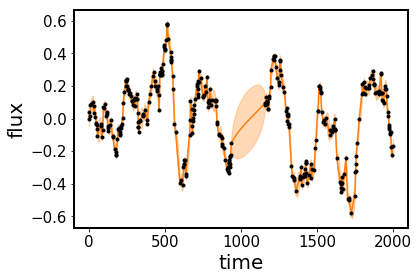

In [86]:
sigma_in = 0.2
tau_in = 100 
kernel = terms.RealTerm(log_a = 2 * np.log(sigma_in) , 
                        log_c = np.log(1/tau_in))
i=0
DirIn = '../raw_data/DRWtestCeleriteZI/'
files = os.listdir(DirIn)
lc = Table.read(DirIn +files[i], format='ascii', names=['time', 'mag', 'err'] )    

start, stop = 200, 250  
# the full observed array has 400 elements. .... 
# we remove some to simulate 'missing data window' ...

t,y,yerr = list(lc['time'][:start])+list(lc['time'][stop:]), \
    list(lc['mag'][:start])+list(lc['mag'][stop:]),\
    list(lc['err'][:start])+list(lc['err'][stop:])

    # call the model  with a chosen kernel instance 
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)

initial_params = gp.get_parameter_vector()

sigma_bounds = [0.001, 1.0]
tau_bounds = [1,10000]


use_bounds = True
prior = 'new'
#for use_bounds, prior in product([True], ['flat', 'exp', 'new']):    
if use_bounds : # use some custom boundaries 
    logc_bounds= (np.log(1/max(tau_bounds)), np.log(1/min(tau_bounds)) )
    loga_bounds = (2*np.log(min(sigma_bounds)), 2*np.log(max(sigma_bounds)))
    bounds = [loga_bounds, logc_bounds]
else : # use the built-in boundaries (-inf : +inf )
    bounds = gp.get_parameter_bounds()

if prior is 'flat' : 
    def neg_log_like(params, y, gp):
        gp.set_parameter_vector(params)
        return -gp.log_likelihood(y)

if prior is 'exp' :
    def neg_log_like(params, y, gp):
        gp.set_parameter_vector(params)
        log_a = params[0]
        log_c = params[1]
        #log_sigma = log_a / 2.0 
        #log_tau = - log_c
        return -gp.log_likelihood(y)  -0.5* (log_c - log_a - np.log(2))

if prior is 'new' : 
    def neg_log_like(params,y,gp):
        gp.set_parameter_vector(params)
        log_a = params[0]
        log_c = params[1]
        log_sigma = log_a / 2.0 
        log_tau = - log_c
        sigma = np.exp(log_sigma)
        tau  = np.exp(log_tau)
        return -gp.log_likelihood(y) - np.log(1.0/sigma + 1.0/tau)

# do the scipy optimize to find the maximum likelihood estimator 
# for hyperparameters.... 
#print('Using %s prior'%prior)
r = minimize(neg_log_like, initial_params, 
             method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)

# retrieve the best-fit parameters 
res = gp.get_parameter_dict()
sigma_fit = np.exp(res['kernel:log_a']/2)
tau_fit = 1.0 / np.exp(res['kernel:log_c'])

# predict the (Gaussian) conditional (on the observed data) 
# distribution for new observations, to get the 
# estimate for standard deviation 

# where should we evaluate prediction ? 
# a) best at the same points at which we are providing hte 
# simulated dataset ... 
#  x = t

# b) at much denser sampling, so that we'll see that 
# the prediction becomes less certain when there is no
# data ... (note region around 1000...)
x = np.linspace(0, 2000, 5000) # t
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

# plot the prediction vs the observations.... 
color = "#ff7f0e"
#plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("time")
plt.ylabel("flux")
plt.savefig(outDir+'DRW_missing_data_celerite_fit.png', bbox_inches='tight')


In [90]:
-gp.log_likelihood(y)

-559.5408895221381

### Calculating the errors on the MLE <a id='error_mle'></a>

[go to top](#toc)

In [142]:
# To find the errors on the MLE sigma, tau, 
# we take the objective function - the neg_log_like , and : 
# 1) calculate the Hessian matrix   H
# 2) calculate the expectation at the minimum returned by the optimizer E[H]
# 3) take the inverse of the Information matrix  ( I = -E[H] ) to get variance 
# 4) take the square root of variance to get standard deviation 

# In the calculation below I follow loosely 
# http://rlhick.people.wm.edu/posts/estimating-custom-mle.html
import numdifftools as nd

def Wrap_neg_log_like(theta) : 
    return neg_log_like(theta, y, gp)

Hfun = nd.Hessian(Wrap_neg_log_like, full_output=True)
hessian_ndt, info = Hfun(r['x'])

# standard deviation is the square of variance
# note  : this error is the error on the 
# MLE of the log_c , log_a 
se = np.sqrt(np.diag(np.linalg.inv(hessian_ndt)))

# Note: 
#parameters : r['x']
#std err : se   ( error on  log_a,  log_c ... )

print(r['x'])

# error from hessian on log_a, log_c
s_log_a = se[0]
s_log_c = se[1]

# these are natural logs
log_a = res['kernel:log_a']
log_c = res['kernel:log_c']

# convert to error on a, c  
s_a = s_log_a * np.exp(log_a)
s_c = s_log_c * np.exp(log_c)

# now a = sigma^2 ,  c = tau^{-1}
# convert to error on sigma, tau 

s_sigma = s_a / (2 * sigma_fit)
s_tau = s_c * tau_fit*tau_fit




[-3.01711956 -4.78624275]


# Compare Celerite to Chelsea <a id='compare'></a>

[go to top](#toc)

"I have attached the fits - the first four columns are:

1. The light curve filename
2. chi^2 of fit
3. log(tau) (in days)
4. log(sigma-hat) (in mag/sqrt(year))

The fit parameters are similar to your input, with: 

$<\tau>$ = 98.5 days 

$<\sigma> = < SF_{\infty} / \sqrt{2} > = 0.2 $ mag


The tau is more biased than sigma, since sigma-hat is well-constrained/not biased, while sigma goes as sqrt(tau).

By the way, the last column list the number of acceptable data points that went into the fit, and sometimes it is <400 because it rejects duplicate MJD values. 
"

### Plot Celerite and Chelsea fit results (global properties) <a id='plotting'></a>

[go to top](#toc)

Using Celerite results from ../data_products/Fig_Celerite_ZI_LC_fits/2017-11-08/ZI_fits_results_11-07-17.npy


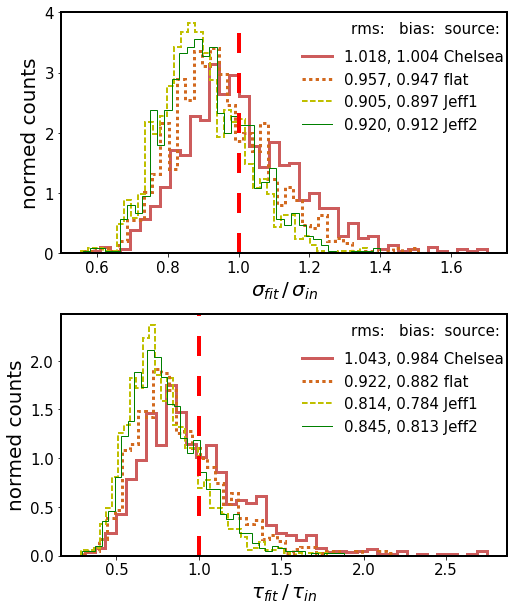

In [36]:
import matplotlib.lines as mlines
%matplotlib inline
# plot histograms : marginalize along either dimension ... 

fig ,ax  = plt.subplots(2,1,figsize=(8,10))

# two panels  : tau and sigma 
sigma_in = 0.2
tau_in = 100 

length = 20 
i = 0 
x0 = [0.2,0.62]

x_max = 2  # maximum sigmafit / sigmain ratio
y_max  = 3 # maximum taufit / tauin ratio 

# Grab Chelsea' results ...
fits = Table.read('../data_products/Fig_Celerite_ZI_LC_fits/'+'fits.dat', 
                  format='ascii')
tau_fit = np.power(10,fits['col3'].data)
sigma_hat = np.power(10, fits['col4'].data)
sigma_fit = sigma_hat / np.sqrt(2 / (tau_fit/365.0)) 
# to convert to mag / sqrt(years)...

# Read the results from Celerite ...
#outDir = '../data_products/Fig_Celerite_ZI_LC_fits/2017-11-08/'
#fname = 'ZI_fits_results_11-07-17.npy'
#results = np.load(outDir+fname).item()
print('Using Celerite results from %s'%(outDir+fname))

# need to store lines for axis legends in an object 
ax_legend_handles = {0:[], 1:[]}

# line settings 
color_dic = {}
ls_dic = {}
lw_dic = {}
data = ['Chelsea', 'flat', 'Jeff1', 'Jeff2', 'p1', 'p2']
colors = ['indianred', 'chocolate', 'y', 'green', 'lightskyblue','darkslateblue']
linestyles = ['solid','dotted','dashed','solid','dashed','dotted']
linewidths  = [3,3,2,1,2,3]
for i in range(len(data)):
    color_dic[data[i]] = colors[i]
    ls_dic[data[i]] = linestyles[i] 
    lw_dic[data[i]]= linewidths[i]

plot_quantities = {'tau':{}, 'sigma':{}}
priors = ['flat', 'p1', 'p2', 'Jeff1', 'Jeff2']
for prior in priors : 
    plot_quantities['tau'][prior] = results[prior]['tau_fit'] / tau_in
    plot_quantities['sigma'][prior] = results[prior]['sigma_fit'] / sigma_in
plot_quantities['sigma']['Chelsea'] =  sigma_fit / sigma_in
plot_quantities['tau']['Chelsea'] =  tau_fit / tau_in

for source in ['Chelsea', 'flat', 'Jeff1', 'Jeff2'] :  #  'p1', 'p2']: # 
    x = plot_quantities['sigma'][source]
    x = x[x<x_max]
    ax[0].hist(x, histtype='step', lw=lw_dic[source], 
              ls=ls_dic[source], bins=40, color=color_dic[source],
              normed=True)
    rms  = np.sqrt(np.mean(np.square(x)))
    bias = np.mean(x)
    line = mlines.Line2D([], [], color=color_dic[source], 
                         lw=lw_dic[source],  ls=ls_dic[source],
                         label=str(rms)[:5]+', '+str(bias)[:5]+' '+source)
    ax_legend_handles[0].append(line)
    
    y = plot_quantities['tau'][source]
    y = y[y<y_max]
    ax[1].hist(y,  histtype='step', color=color_dic[source], 
               lw=lw_dic[source],  ls=ls_dic[source], bins=40, 
               normed=True)
    rms  = np.sqrt(np.mean(np.square(y)))
    bias = np.mean(y)
    line = mlines.Line2D([], [], color=color_dic[source], 
                         lw=lw_dic[source],  ls=ls_dic[source],
                         label=str(rms)[:5]+', '+str(bias)[:5]+' '+source)
    ax_legend_handles[1].append(line)
    

ax[0].set_xlabel(r'$\sigma_{fit}\,/ \,\sigma_{in}$')
ax[1].set_xlabel(r'$\tau_{fit} \,/\, \tau_{in}$')

for i in [0,1]:
    ax[i].legend(loc='upper left', handles = ax_legend_handles[i], frameon=False,
                bbox_to_anchor=(0.51, 0.9), fontsize=15)
    ax[i].axvline(1, lw=4, ls='--', c='red', dashes=(5,5))
    ax[i].set_ylabel('normed counts')
    ax[i].text(0.65, 0.91, 'rms:   bias:  source: ',
               transform=ax[i].transAxes, fontsize=15)


    
fig.subplots_adjust(hspace=0.25)
#fig.suptitle('N = '+str(len(t))+', length = '+str(length)+  r'$ \tau_{in}$,'+' '\
#                 +str(len(x))+' fits' + '\n' \
#                 + 'err='+str(yerr[0])+' [mag], '+b, fontsize=20)
plt.savefig(outDir + 'sigma_tau_ratios_chelsea_celerite1.png', bbox_inches='tight')
# in each panel , plot histogram of both 

Plot the best-fit $\sigma$  vs $\tau$ : 

In [9]:
results.keys()

dict_keys(['flat', 'p1', 'p2'])

/Users/chris/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:51: RuntimeWarning: divide by zero encountered in log10


flat sigma 0.191570131506
flat tau 92.279512304
p1 sigma 0.208653876392
p1 tau 112.317020027
p2 sigma 0.201913306057
p2 tau 104.081424303
Jeff1 sigma 0.18111567296
Jeff1 tau 81.4052039283
Jeff2 sigma 0.184147059847
Jeff2 tau 84.5331163662
Chelsea sigma 0.203633409545
Chelsea tau 104.337237482


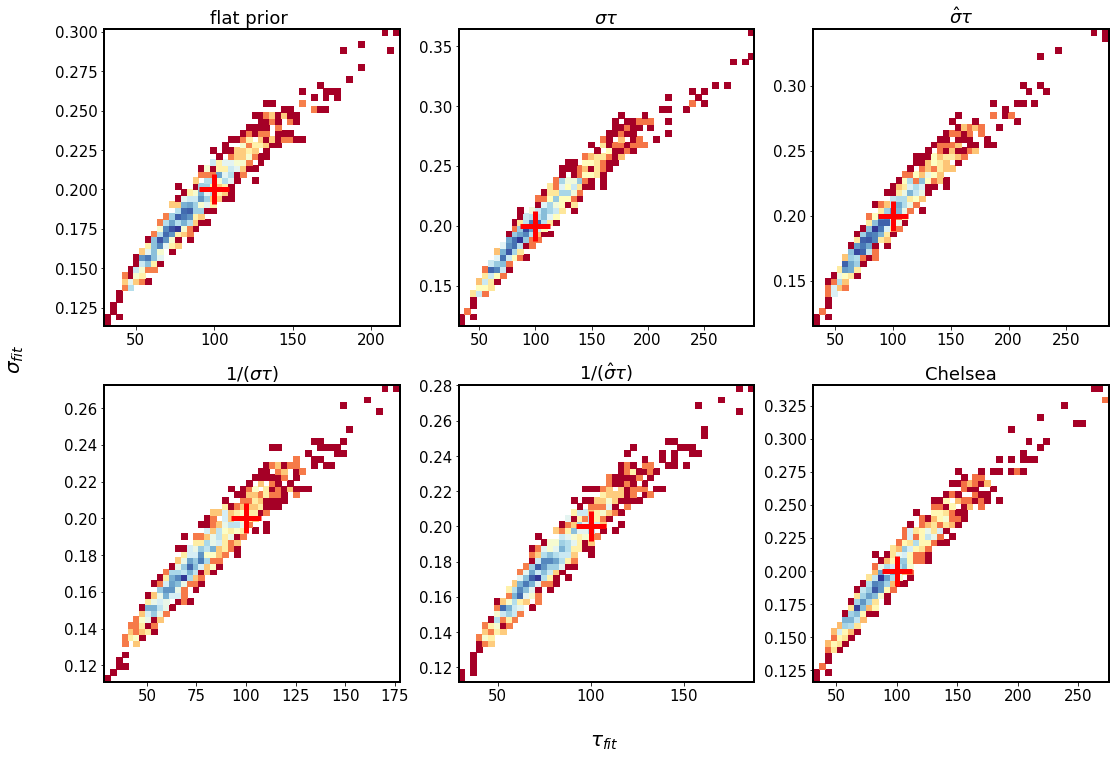

In [47]:
%matplotlib inline
from scipy.stats import binned_statistic_2d
fig,axs = plt.subplots(2,3,figsize=(18,12))
ax = np.ravel(axs)

plot = {'tau':{}, 
        'sigma':{}
       }
for prior in ['flat', 'p1','p2', 'Jeff1', 'Jeff2']:
    plot['tau'][prior] = results[prior]['tau_fit'] 
    plot['sigma'][prior] = results[prior]['sigma_fit'] 

fits = Table.read('../data_products/Fig_Celerite_ZI_LC_fits/'+'fits.dat', 
                  format='ascii')
tau_fit = np.power(10,fits['col3'].data)
sigma_hat = np.power(10, fits['col4'].data)
sigma_fit = sigma_hat / np.sqrt(2 / (tau_fit/365.0)) 
plot['sigma']['Chelsea'] =  sigma_fit 
plot['tau']['Chelsea'] =  tau_fit 

ax_title = {'flat':'flat prior ', 
           'p1' : r'$\sigma \tau$',
           'p2': r'$\hat{\sigma} \tau$',
           'Jeff1': r'$1 / (\sigma \tau)$', 
           'Jeff2': r'$1/(\hat{\sigma} \tau)$',
           'Chelsea' : 'Chelsea'}

i=0
x0 = [0.2,0.4,0.6]

dict_a = {}
for source in ['flat', 'p1','p2', 'Jeff1', 'Jeff2', 'Chelsea']:
    dict_a[source]  = {}
    sigma = plot['sigma'][source]
    tau = plot['tau'][source]
    mx = sigma < 0.5 
    my = tau < 300 
    m = mx * my 
    x = sigma[m]
    y = tau[m]

    # Plot 2D histogram using pcolor
    stats = binned_statistic_2d(y,x,y, statistic='count', bins=50)
    z_sigma, x_edges, y_edges = stats[0], stats[1], stats[2]
    z_sigma[np.isnan(z_sigma)] =0 # replace all nan's by 0 ...
    z_reduce  =  z_sigma
    z_min, z_max = z_reduce.min(), np.abs(z_reduce).max()
    z_rot = np.rot90(z_reduce)  # rotate and flip to properly display... 
    z_rot_flip = np.flipud(z_rot)
    z_masked = np.ma.masked_where(z_rot_flip == 0 , z_rot_flip)
    image = ax[i].pcolormesh(x_edges,y_edges, np.log10(z_masked), 
                             cmap=plt.cm.get_cmap('RdYlBu'))
    #cax = fig.add_axes([x0, 0.8, 0.4,0.02])
    #colorbar = fig.colorbar(image, cax=cax, orientation='horizontal')
    #from matplotlib import ticker
    #tick_locator = ticker.MaxNLocator(nbins=5)
    #colorbar.locator = tick_locator
    #colorbar.update_ticks()
    #colorbar.set_label(r'$\log_{10}(\mathrm{counts})$')
    print(source,'sigma', np.sqrt(np.mean(np.square(x))))
    print(source,'tau', np.sqrt(np.mean(np.square(y))))
    dict_a[source]['rms_sigma'] = np.sqrt(np.mean(np.square(x)))
    dict_a[source]['rms_tau'] = np.sqrt(np.mean(np.square(y)))
    dict_a[source]['std_sigma']  = np.std(x)
    dict_a[source]['std_tau'] = np.std(y)
    
    ax[i].plot(100,0.2,marker='+', markersize=30,
            markerfacecolor='white', 
            markeredgewidth=5.0,
           markeredgecolor='red')
    ax[i].set_title( ax_title[source])
    i+=1
fig.text(0.5,0.05, r'$\tau_{fit}$', fontsize=20)
fig.text(0.05, 0.5, r'$\sigma_{fit}$', rotation=90, fontsize=20)
fig.subplots_adjust(wspace=0.2)
plt.savefig(outDir+'sigma_vs_tau.png')
plt.show()

In [26]:
dict_b = {}
for prior in ['flat', 'p1','p2', 'Jeff1', 'Jeff2']:
    dict_b[prior] = {}
    s_tau = results[prior]['s_tau']
    s_tau = s_tau[np.bitwise_not(np.isnan(s_tau))]
    
    s_sigma = results[prior]['s_sigma']
    s_sigma = s_sigma[np.bitwise_not(np.isnan(s_sigma))]
    
    print(np.mean(s_tau), np.mean(s_sigma))
    dict_b[prior]['mean_s_tau'] = np.mean(s_tau)
    dict_b[prior]['mean_s_sigma'] = np.mean(s_sigma)
    
    

26.9733933351 0.0275850463801
46.27696859 0.0410838220348
36.0642678163 0.0343298055845
20.3683447299 0.0222676096605
22.1277384901 0.0237085119261


In [33]:
dict_a.pop('Chelsea', None)

{'rms_sigma': 0.20363340954499307, 'rms_tau': 104.33723748172837}

In [35]:
dict_b

{'Jeff1': {'mean_s_sigma': 0.022267609660508274,
  'mean_s_tau': 20.36834472989143},
 'Jeff2': {'mean_s_sigma': 0.023708511926075683,
  'mean_s_tau': 22.127738490068705},
 'flat': {'mean_s_sigma': 0.027585046380137753,
  'mean_s_tau': 26.973393335063324},
 'p1': {'mean_s_sigma': 0.041083822034826238, 'mean_s_tau': 46.27696859003445},
 'p2': {'mean_s_sigma': 0.034329805584451104,
  'mean_s_tau': 36.064267816319038}}

In [48]:
dict_a

{'Chelsea': {'rms_sigma': 0.20363340954499307,
  'rms_tau': 104.33723748172837,
  'std_sigma': 0.032843054743282946,
  'std_tau': 34.422189215079676},
 'Jeff1': {'rms_sigma': 0.18111567295976011,
  'rms_tau': 81.405203928257308,
  'std_sigma': 0.023898527343633864,
  'std_tau': 21.658915505498442},
 'Jeff2': {'rms_sigma': 0.18414705984692706,
  'rms_tau': 84.533116366222288,
  'std_sigma': 0.024918071499582636,
  'std_tau': 23.07564741222253},
 'flat': {'rms_sigma': 0.19157013150640265,
  'rms_tau': 92.279512304020074,
  'std_sigma': 0.027712520932928589,
  'std_tau': 26.995996599185663},
 'p1': {'rms_sigma': 0.20865387639245969,
  'rms_tau': 112.31702002653991,
  'std_sigma': 0.035606270311310778,
  'std_tau': 38.904370175017213},
 'p2': {'rms_sigma': 0.20191330605733374,
  'rms_tau': 104.08142430288095,
  'std_sigma': 0.032507818676234874,
  'std_tau': 34.094060715128791}}

In [51]:
p = ['Jeff1', 'Jeff2', 'flat', 'p1', 'p2']
rms_sigma = [0.18111567295976011,  0.1841470598469270,  0.191570131506402, 
            0.2086538763924596,0.20191330605733]
rms_tau = [81.40520392825730, 84.53311636622228,92.27951230402007,
          112.3170200265399, 104.081424302880]
mean_s_sigma = [0.02226760966050, 0.0237085119260756,0.02758504638013,
               0.04108382203482, 0.034329805584451] 
mean_s_tau = [20.3683447298914, 22.12773849006870, 26.9733933350633,
             46.276968590034, 36.064267816319]

std_sigma = [0.02389852, 0.0249180714995, 0.02771252093292,  
             0.035606270311310, 0.03250781867623487]
std_tau = [21.6589155054, 23.075647412222, 26.99599659918, 
           38.904370175017, 34.09406071512879]
table = Table([p,rms_sigma,mean_s_sigma,std_sigma, rms_tau,mean_s_tau,   std_tau ], 
              names=('prior', 'rms_sigma','mean_s_sigma', 'std_sigma',  'rms_tau',
                     'mean_s_tau','std_tau'))

In [52]:
table

prior,rms_sigma,mean_s_sigma,std_sigma,rms_tau,mean_s_tau,std_tau
str5,float64,float64,float64,float64,float64,float64
Jeff1,0.18111567296,0.0222676096605,0.02389852,81.4052039283,20.3683447299,21.6589155054
Jeff2,0.184147059847,0.0237085119261,0.0249180714995,84.5331163662,22.1277384901,23.0756474122
flat,0.191570131506,0.0275850463801,0.0277125209329,92.279512304,26.9733933351,26.9959965992
p1,0.208653876392,0.0410838220348,0.0356062703113,112.317020027,46.27696859,38.904370175
p2,0.201913306057,0.0343298055845,0.0325078186762,104.081424303,36.0642678163,34.0940607151


## Combine Celerite and Chelsea results, save as a table <a id='save'></a>

[go to top](#toc)

In [17]:
#results['flat'].keys()

dict_keys(['sigma_fit', 'tau_fit', 's_sigma', 's_tau', 's_loga', 's_logc'])

In [40]:
# Make an AstroPy table from Celerite fit results 
celerite_fits = Table()
celerite_fits['name'] = results['lc_name']
for prior in priors : 
    for key in results[prior].keys():
        colname = prior + '-'+key
        celerite_fits[colname] = results[prior][key]
        
# Make an AstroPy table from Chelsea fit results        
fits = Table.read(outDir[:-11]+ 'fits.dat', format='ascii')
chelsea_fits = Table()
chelsea_fits['name'] = fits['col1']
chelsea_fits['Chelsea_tau'] = np.power(10,fits['col3'].data)
sigma_hat = np.power(10, fits['col4'].data)
chelsea_fits['Chelsea_sigma']  = sigma_hat / np.sqrt(2 / (tau_fit/365.0))
#  to convert to mag / sqrt(years)...

# merge on name 
from astropy.table import join
combined = join(celerite_fits, chelsea_fits)

# save the result ...
fname = 'celerite_chelsea_fit_results.txt'
combined.write(outDir + fname, format='ascii', overwrite='True')
print('Combined results saved as %s '%(outDir+fname))

Combined results saved as /Users/chris/GradResearch/DRW_Celerite/data_products/Fig_Celerite_ZI_LC_fits/2017-11-14/celerite_chelsea_fit_results.txt 


"I have attached the fits - the first four columns are:

1. The light curve filename
2. $\chi^2$ of fit
3. log(tau) (in days)
4. log(sigma-hat) (in mag/sqrt(year))

The fit parameters are similar to your input, with: 

$<\tau>$ = 98.5 days 

$<\sigma> = < SF_{\infty} / \sqrt{2} > = 0.2 $ mag


The tau is more biased than sigma, since sigma-hat is well-constrained/not biased, while sigma goes as sqrt(tau).

By the way, the last column list the number of acceptable data points that went into the fit, and sometimes it is <400 because it rejects duplicate MJD values. 
"

In [129]:
prior = 'flat'
np.mean(results[prior]['s_sigma'])

0.027585046380137753

In [128]:
results[prior].keys()

dict_keys(['sigma_fit', 'tau_fit', 's_sigma', 's_tau', 's_loga', 's_logc'])

In [130]:
for prior i results[prior]['s_sigma']

0.026236452833659451